In [1]:
%matplotlib nbagg
import sys
import csv
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
"""
 Loop between two dates
"""

def fill_date(dt_start, dt_end):
    datai = datetime.strptime(dt_start, "%Y%m%d")
    dataf = datetime.strptime(dt_end, "%Y%m%d")
    delta = 1
    data = datai
    while (data <= dataf):
        print data.strftime("%Y-%m-%d")
        data = data + timedelta(days=delta)
    return

def openCSV(filename):
    """ Reads file contents and returns it as a two dimensional numpy array (JD, S)"""
    with open(filename) as csvfile:
        reader = csv.reader(csvfile, delimiter='\t')
        data = [r for r in reader]

    dateS=np.zeros(( len(data) - 1,2 ))
    j = 0
    for i in data[1:]:
        dateS[j,0] = float(i[0])
        dateS[j,1] = float(i[4])
        j += 1

    return dateS


def getInitFinalDate(dateFile):
    """ From read array, returns initial and final days """
    return dateFile[0,0], dateFile[-1,0]


def fill(dateFile, timeSpan = 1):
    """ Returns an array between initial and final days, spanned by the timeSpan variable """
    iD, fD = getInitFinalDate(dateFile)
    return np.arange(iD, fD+1, timeSpan)


def fill_Date_julian(dateFile, timeSpan = 1):
    """ 
    Compares between the full range period array and the experimental one.
    Returns a three dimensional array within the first column with the continuous days span,
    the second column with the rearranged S values, at missing dates spots zeros were included
    and the third column with the original S values, with previous S values at missing spots.    
    """
    
    full = fill(dateFile,timeSpan)
    j = 0
    k = 0
    
    rescaled = np.empty((len(full), 2 ))
    for i in dateFile[:,0]:
        
        while full[j] != i:
            
            rescaled[j,0] = full[j]
            rescaled[j,1] = np.nan
                        
            j += 1
            if j >= len(full):
                break
        
        
        if j >= len(full):
                break
        else:
            rescaled[j,0] = full[j]
            rescaled[j,1] = dateFile[k,1]
            j += 1
        
        k += 1         
        
    return rescaled
        
    
def order_mean(dateFile, order = 3):
    """
    Returns an array with the order_th mean, order defaut value is 3.
    The ith value is the mean value between it and its order_th predecessors neighbors
    """
    meanvec = np.zeros(len(dateFile[:,1]))
    for i in range(order):
        meanvec[i] = None
    
    for i in range(order-1, len(dateFile[:,0])):        
        sumArr = []
        for j in range(order):
            
            if np.isnan(dateFile[i-j,1]) == False:
                sumArr.append( dateFile[i-j,1] )
                
        if len(sumArr) == 0:
            mean = None
        else:
            mean = sum(sumArr)/len(sumArr)
            
            
        meanvec[i] = mean
           
    return meanvec 


def interpolatePandas(filename_CSV):
    """
    Returns interpolated data using Pandas library
    It first opens up the csv file named "filename_CSV", makes the interpolation and saves to "interpolated.csv".
    After that, it reads interpolated file and saves it to the 2D - array dateS 
    """
    data_CSV = pd.read_csv(filename_CSV, sep='\t', parse_dates=True, infer_datetime_format=True, index_col=1, header=0)
    dt_resample = data_CSV.resample('1 D').interpolate()
    dt_resample.to_csv('interpolated.csv')

    with open('interpolated.csv') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        data = [r for r in reader]

        dateS=np.zeros(( len(data) - 1,2 ))
        j = 0
        for i in data[2:]:
        #print i[4]
            dateS[j,0] = float(i[1])
            dateS[j,1] = float(i[4])
            j += 1

    return dateS[:-1,0],dateS[:-1,1]

def fakeness_backDist(interpolated, real):
    """
    Returns an 3D integers array with the fakness of the data, the backward distance and forward distance.
    eqInd[:,0] -> if the data is real, returns +1, else if it is fake (interpolated) returns -1
    eqInd[:,1] -> backward distance between current fake data and last real data
    eqInd[:,2] ->  forward distance between current fake data and next real data
    at real data spots, eqInd[:,1] and eqInd[:,1] are set to be -1
    """

    eqInd = - np.ones(( len(interpolated),3 ) , dtype=int) #3D array 
    j=0
    for i in range(1,len(real)):
        k = 0
        while interpolated[j] != real[i,1]:        
            eqInd[j,1] = int(k) #updating backward distance between current fake data and last real data
            k += 1
            j += 1
        eqInd[j,0] = int(1)

    
    positiveIndex = np.where(eqInd[:,0] == 1)[0]

    k = 0
    for i in  positiveIndex:
        for j in range(k,i):
            eqInd[j,2] = i-j
        k = i

    zeroIndex = np.where(eqInd[:,1] == 0) #changing zero distance by -1 - IS IT NECESSARY???
    eqInd[zeroIndex,1] = -1
    eqInd[zeroIndex,2] = -1
    
    return eqInd

SyntaxError: invalid syntax (<ipython-input-2-a23b92590cc2>, line 11)

In [144]:
dateFile = openCSV('ov236_048GHz.csv')
iD, fD = getInitFinalDate(dateFile)
fullRange = fill(dateFile,1)

print 'initial date (JD)= %f, final date (JD)= %f' %(iD, fD)
print fullRange[0], fullRange[-1]

initial date (JD)= 2444009.500000, final date (JD)= 2455880.500000
2444009.5 2455880.5


In [145]:
rescaled = fill_Date_julian( dateFile,1 )

threeMean = order_mean(rescaled, order = 3)
fourMean = order_mean(rescaled, order = 4)
#fiveMean = order_mean(rescaled, order = 50)
#print fiveMean[:50]

<IPython.core.display.Javascript object>


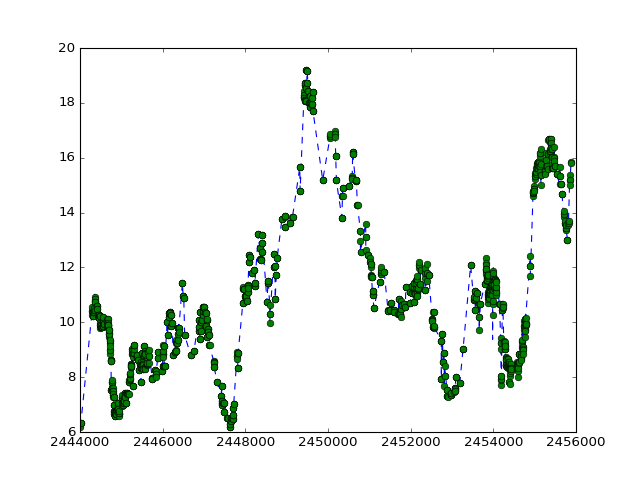

In [146]:
interpX,interpY = interpolatePandas('ov236_048GHz.csv')
plt.plot(interpX,interpY,'--',rescaled[:,0],threeMean, 'o')

In [149]:
fakeBackFor = fakeness_backDist(interpY, dateFile)

<IPython.core.display.Javascript object>


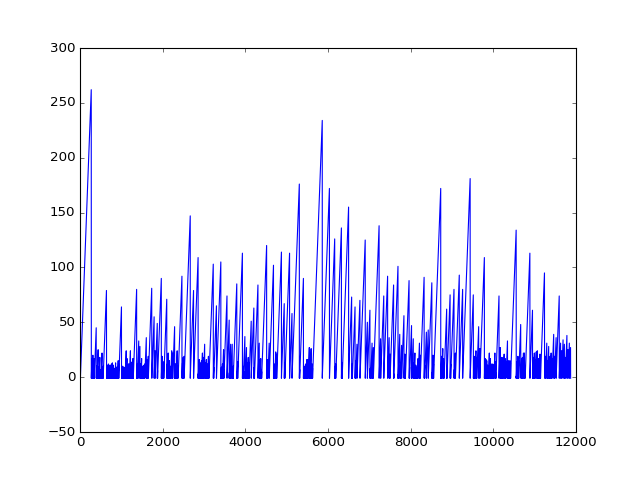

In [151]:
plt.plot(fakeBackFor[:,1])

In [12]:
#
# MAIN PROGRAM
#
#def main(argv=None):
    #fill_date("19760105","19771220")
	#dateFile = openCSV('ov236_048GHz.csv')
	#iD, fD = getInitFinalDate(dateFile)
	#print 'initial date (JD)= %f, final date (JD)= %f' %(iD, fD)

#if __name__ == "__main__":
    #sys.exit(main())
#    main()
